In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyperdt install

In [15]:
# %%bash
# which python
# cd ~
# git clone https://github.com/qc2321/hyperDT # Quentin's updated version of hyperDT
# cd hyperDT
# pip install -e .

In [16]:
# %%bash
# pip install geomstats

# HyperDT benchmark - Gaussian mixtures

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import embedders

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

/Users/phil/hyperDT_with_submodules/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2


0.925
0.87


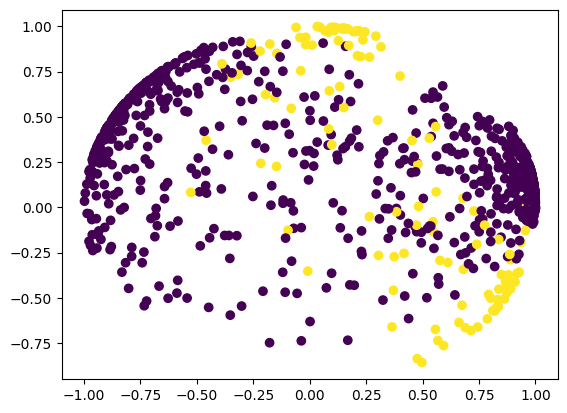

In [18]:
# Basic structure: let's do H2, but with a really high curvature

signature = [(-4, 2)]
pm = embedders.manifolds.ProductManifold(signature=signature)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, seed=42, cov_scale_means=1.0, cov_scale_points=1.0)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# hyperDT
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=1)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# sklearn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# Also let's visualize the points
X_poincare = embedders.visualization.hyperboloid_to_poincare(X)
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)

In [20]:
%%prun

import embedders

# Filter UserWarning for singular matrix in gaussian mixture method
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

results = []

CURVATURES = [-4, -2, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_SAMPLES = 50
N_POINTS = 1_000
N_CLASSES = 10

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)])

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm, seed=seed, num_points=N_POINTS, num_classes=N_CLASSES, cov_scale_means=1.0, cov_scale_points=1.0
        )

        # Benchmarks are now handled by the benchmark function
        # accs = embedders.benchmarks.benchmark(X, y, pm, classifiers=["sklearn_dt", "product_dt", "tangent_dt"])
        accs = embedders.benchmarks.benchmark(X, y, pm)
        accs["curvature"] = K
        accs["seed"] = seed
        results.append(accs)

        my_tqdm.update(1)

results = pd.DataFrame(results)

# Save these results
results.to_csv(
    "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks.csv", index=False
)

  0%|          | 0/500 [00:00<?, ?it/s]

         309822234 function calls (278254759 primitive calls) in 1233.529 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 30351365  432.088    0.000  432.088    0.000 tree_new.py:12(_angular_greater)
      500  145.683    0.291  533.192    1.066 tree_new.py:398(fit)
   353324  132.892    0.000  187.160    0.001 tree_new.py:27(_get_info_gains)
   353324  119.524    0.000  122.633    0.000 tree_new.py:69(_get_split)
 30299865   90.689    0.000  605.163    0.000 tree_new.py:324(_left)
 30577876   49.847    0.000   49.847    0.000 {built-in method torch.tensor}
 60599730   47.100    0.000   47.100    0.000 {method 'flatten' of 'torch._C.TensorBase' objects}
757148/50500   33.876    0.000  390.531    0.008 tree_new.py:282(_fit_node)
  1413296   26.434    0.000   26.434    0.000 {built-in method torch.rsub}
  2576268   23.058    0.000   23.122    0.000 {method 'sum' of 'torch._C.TensorBase' objects}
   353324   17.620    0.000  

In [28]:
matplotlib.use("pdf")

In [30]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib

# matplotlib.use("pgf")
import matplotlib.pyplot as plt
import numpy as np

# import tikzplotlib


# Load results
# results = pd.read_csv(
#     "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks.csv"
# )
CURVATURES = [-4, -2, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]

from scipy.stats import ttest_rel

# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt"]
model_names1 = ["Product DT", "Euclidean DT (ambient)", "Euclidean DT (tangent plane)"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf"]
model_names2 = ["Product RF", "Euclidean RF (ambient)", "Euclidean RF (tangent plane)"]
colors = ["C0", "C1", "C2"]

# Initialize plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models1) + 1)

for ax, models, model_names in zip(axs, [models1, models2], [model_names1, model_names2]):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["curvature"] == K][model] for K in CURVATURES],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=2),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=2)
        plt.setp(bp["medians"], color="black", linewidth=2)
        plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

        bps.append(bp)

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(CURVATURES)  # How many annotations per curvature
    for i, j in [(0, 1), (1, 2), (0, 2)]:
        results_K = [results[results["curvature"] == K] for K in CURVATURES]
        p_vals = [ttest_rel(res[models[i]], res[models[j]]).pvalue for res in results_K]

        for k, p_val in enumerate(p_vals):
            if p_val < 0.05:
                x1, x2 = x_vals[k] + i, x_vals[k] + j
                y = results[results["curvature"] == CURVATURES[k]][models].max().max() + 0.04 * (heights[k] + 1)
                ax.text(
                    s="*", x=(x1 + x2) / 2, y=y, ha="center", va="center", color="black", fontdict={"weight": "bold"}
                )
                ax.plot([x1, x1, x2, x2], [y - 0.02, y - 0.01, y - 0.01, y - 0.02], lw=2, color="black")
                heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-ticks
    ax.set_ylabel("F1 Score", fontsize=14)
    # ax.set_title("D", fontsize=16)
    ax.set_xticks(x_vals + 1, CURVATURES, fontsize=14)
    ax.legend([bp["boxes"][0] for bp in bps], model_names, loc="upper right", fontsize=14, frameon=False)
    # ax.set_xlabel("Curvature", fontsize=14)
    ax.tick_params(axis="y", labelsize=14)

axs[0].set_title("Decision Trees", fontsize=16)
axs[1].set_title("Random Forests", fontsize=16)
axs[1].set_xlabel("Curvature", fontsize=14)

plt.xlim(-1, len(CURVATURES) * (len(models1) + 1))

# Transparent
plt.tight_layout()
plt.show()

# Save as pdf
# plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_dt.pdf")
# plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_mixed.pdf")

# Save as tikz
# plt.savefig("/teamspace/studios/this_studio/embedders/figures/curvature_benchmarks_mixed.pgf")

# HyperDT benchmark - by signature

In [ ]:
SIGNATURES = [
    # [(-1, 10)],
    # [(0, 10)],
    # [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

SIGNATURES_STR = [
    # "H(-1, 10)",
    # "E(0, 10)",
    # "S(1, 10)",
    "H(-1, 5)^2",
    "S(1, 5)^2",
    "H(-1, 5) x \n S(1, 5)",
    "H(-1, 2)^5",
    "S(1, 2)^5",
    "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
]

In [ ]:
import embedders
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

INFO: Using numpy backend


device(type='cpu')

In [ ]:
from tqdm.notebook import tqdm

import pandas as pd
import embedders
import hyperdt

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

results2 = []

N_POINTS = 1000
N_TRIALS = 50
N_CLASSES = 4
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.3

my_tqdm = tqdm(total=len(SIGNATURES) * N_TRIALS)
for i, signature in enumerate(SIGNATURES):
    for seed in range(N_TRIALS):
        # Ensure unique seed per trial
        seed = seed + N_TRIALS * i
        pm = embedders.manifolds.ProductManifold(signature=signature, device=device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            cov_scale_means=COV_SCALE_MEANS,
            cov_scale_points=COV_SCALE_POINTS,
        )
        accs = embedders.benchmarks.benchmark(
            X,
            y,
            pm,
            device=device,
            classifiers=[
                "sklearn_dt",
                "tangent_dt",
                "product_dt",
                "product_dt_legacy",
                "sklearn_rf",
                "product_rf",
                "tangent_rf",
                "product_rf_legacy",
            ],
            score="accuracy",
        )
        accs["signature"] = SIGNATURES_STR[i]
        accs["seed"] = seed
        results2.append(accs)

        my_tqdm.update(1)

results2 = pd.DataFrame(results2)

results2.to_csv(
    "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/signature_benchmarks.csv", index=False
)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# Turn table into 95% confidence intervals with p-values
import numpy as np
from scipy.stats import ttest_rel

start_str = """
\\begin{tabular}{cccccccc}
    \\toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
    \\hline
"""

SIGNATURES_LATEX = [
    # "\\H{10}",
    # "\\E{10}",
    # "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

suffix = ""


print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    for model in ["product_dt", "sklearn_dt", "tangent_dt", "product_rf", "sklearn_rf", "tangent_rf"]:
    # for model in [f"product_dt{suffix}", "sklearn_dt", "tangent_dt"]:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        pre, post = model.split("_")[0], model.split("_")[1]
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        if mean > _p.mean() and ttest_rel(r[model], _p).pvalue < 0.05:
            asts.append("*")
        if mean > _e.mean() and ttest_rel(r[model], _e).pvalue < 0.05:
            asts.append("\dagger")
        if mean > _t.mean() and ttest_rel(r[model], _t).pvalue < 0.05:
            asts.append("\ddagger")
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)


\begin{tabular}{cccccccc}
    \toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\
    \hline

	$(\H{5})^2$	& $\mathbf{98.9 \pm 0.3}$	& $98.4 \pm 0.5$	& $98.6 \pm 0.4$	& $99.1 \pm 0.3^{\dagger}$	& $98.5 \pm 0.5$	& $\mathbf{99.5 \pm 0.3^{*\dagger}}$	\\
	$(\S{5})^2$	& $65.9 \pm 2.1^{\ddagger}$	& $\mathbf{72.9 \pm 2.6^{*\ddagger}}$	& $61.1 \pm 2.0$	& $70.8 \pm 1.9^{\ddagger}$	& $\mathbf{74.7 \pm 1.7^{*\ddagger}}$	& $66.4 \pm 1.6$	\\
	$\H{5} \times \S{5}$	& $\mathbf{97.2 \pm 0.8^{\dagger\ddagger}}$	& $94.5 \pm 1.1$	& $96.2 \pm 1.0^{\dagger}$	& $\mathbf{97.2 \pm 0.7^{\dagger\ddagger}}$	& $94.5 \pm 1.1$	& $96.1 \pm 1.0^{\dagger}$	\\
	$(\H{2})^5$	& $\mathbf{96.5 \pm 0.9^{\dagger}}$	& $95.5 \pm 1.0$	& $96.0 \pm 1.0^{\dagger}$	& $97.0 \pm 0.8$	& $96.9 \pm 0.9$	& $\mathbf{97.6 \pm 0.7^{\dagger}}$	\\
	$(\S{2})^5$	&

In [ ]:
# Turn table into 95% confidence intervals with p-values
import numpy as np
from scipy.stats import ttest_rel

start_str = """
\\begin{tabular}{cccccccc}
    \\toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
    \\hline
"""

SIGNATURES_LATEX = [
    # "\\H{10}",
    # "\\E{10}",
    # "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

suffix = ""


print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    for model in ["product_dt_legacy", "sklearn_dt", "tangent_dt", "product_rf_legacy", "sklearn_rf", "tangent_rf"]:
    # for model in [f"product_dt{suffix}", "sklearn_dt", "tangent_dt"]:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        pre, post = model.split("_")[0], model.split("_")[1]
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        if mean > _p.mean() and ttest_rel(r[model], _p).pvalue < 0.05:
            asts.append("*")
        if mean > _e.mean() and ttest_rel(r[model], _e).pvalue < 0.05:
            asts.append("\dagger")
        if mean > _t.mean() and ttest_rel(r[model], _t).pvalue < 0.05:
            asts.append("\ddagger")
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)


\begin{tabular}{cccccccc}
    \toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\
    \hline

	$(\H{5})^2$	& $98.6 \pm 0.6$	& $98.4 \pm 0.5$	& $98.6 \pm 0.4$	& $98.8 \pm 0.6$	& $98.5 \pm 0.5$	& $\mathbf{99.5 \pm 0.3^{*\dagger}}$	\\
	$(\S{5})^2$	& $65.4 \pm 2.1^{\ddagger}$	& $\mathbf{72.9 \pm 2.6^{*\ddagger}}$	& $61.1 \pm 2.0$	& $68.7 \pm 1.9^{\ddagger}$	& $\mathbf{74.7 \pm 1.7^{*\ddagger}}$	& $66.4 \pm 1.6$	\\
	$\H{5} \times \S{5}$	& $\mathbf{97.2 \pm 0.8^{\dagger\ddagger}}$	& $94.5 \pm 1.1$	& $96.2 \pm 1.0^{\dagger}$	& $97.3 \pm 0.7^{\dagger\ddagger}$	& $94.5 \pm 1.1$	& $96.1 \pm 1.0^{\dagger}$	\\
	$(\H{2})^5$	& $94.1 \pm 1.2$	& $95.5 \pm 1.0$	& $96.0 \pm 1.0^{\dagger}$	& $94.8 \pm 1.0$	& $96.9 \pm 0.9$	& $\mathbf{97.6 \pm 0.7^{\dagger}}$	\\
	$(\S{2})^5$	& $83.2 \pm 1.9^{\ddagger}$	& $\mathbf{88.1 \pm 